The Market
==========

## Orders

We are interested in the modeling of financial markets. In particular the modeling of double auction markets. Unlike in a regular auction, where only buyers compete, in double auctions both buyers and sellers participate. Buyers place bids, sellers place asks and the market finds a way to match them together. A bid consists of a price 𝑃 and a volume 𝑉, such that a bidder guarantees he will buy any number under 𝑉 for any price under 𝑃. An asks consists of a price 𝑃 and a volume 𝑉, such that an asker guarantees he will sell any number under 𝑉 for any price over 𝑃. Bids and asks are called orders and are collected in an order book. This is how most stock exchanges work. 

![orderbook](./assets/orderbook.png)

We can implement this simple behaviour in Python:

In [ ]:
from enum import Enum

class OrderType(Enum):
    BUY = 1
    SELL = 2

class Order:

    def __init__(self, agent_id, type, price, qty):
        self.agent_id = agent_id
        self.type = type
        self.price = price
        self.qty = qty
        
    def __str__(self):
        return "<%s, %d, %d>" % (self.type, self.price, self.qty)
    
    def __repr__(self):
        return str(self)

class Market:
    orders = []
    
    def submit(self, order):
        self.orders.append(order)

## Matching

The Market must find a way to match bidders and askers. There are many ways to do this that suit the needs of different exchanges. We are going to use a simple matching technique called "1/2-Double Auction". It works by calculating a market price based on all bids and all asks and clearing the market with this price. That is to say, all asks bellow this price and all bids above are all cleared with the market price. It works as follow: Sort the bids in ascending order $B_1, \geq B_2 \geq B_3 \dots$ and the asks in descending order $S_1 \leq S_2 \leq S_3 \dots$. Find the maximum trade quantity $l$ such that $B_l > S_l$. Calculate the market price as $(B_l + S_l) / 2$. Clear with this price.

This matching technique does not include volume. However, since our market won't discriminate based on volume or have preferences towards traders, we can easily modify to account for volume as well. We can implement this behaviour in `class Market`.

In [2]:
class Market:
    orders = []
    market_price = 0
    
    def submit(self, order):
        self.orders.append(order)
    
    def clear(self):
        """Calculate a new market_price and clear the market"""
        
        type_is = lambda x: list(filter(lambda y: y.type is x, self.orders))    
        
        asks = type_is(OrderType.SELL)
        bids = type_is(OrderType.BUY)
        
        price = lambda x: x.price
        
        asks.sort(key=price)
        bids.sort(reverse=True, key=price)
        
        market_price = 0;
        
        i, j = 0, 0
        
        while True:
            bid, ask = bids[i], asks[j]          
            
            if bid.price >= ask.price and bid.qty < ask.qty:
                ask.qty -= bid.qty
                i += 1
            elif bid.price >= ask.price and bid.qty > ask.qty:
                bid.qty -= ask.qty
                j += 1
            elif bid.price >= ask.price and bid.qty == ask.qty:
                i += 1
                j += 1

            if bid.price < ask.price or i >= len(bids) or j >= len(asks):
                for x in range(0, i):
                    self.fulfill_order(bids[x])
                
                for y in range(0, j):
                    self.fulfill_order(asks[y])
                    
                break
                
            market_price = (bid.price + ask.price) / 2

        self.market_price = market_price
        
    def fulfill_order(self, order):
        """Fulfill an order. Currently - as we have no actors - we simply remove it from the order book"""
        
        self.orders.remove(order)

# The Actors

Actors interact and learn from the environment. They are described by their policy $\pi$, which dictates which actions they would take in the current state of the environment. Formally, $\pi(a | s)$ is the probability of taking action $a$ in the state $s$. 

The actions $a$ and the states $s$ are members of the action space and the state space. Our action space consists of choosing one of either "BUY", "SELL" or "HOLD" as well as a price and a volume. Here we notice a problem - as we have defined it, our action space is practically infinite, as actors can choose any volume and any price. Because there is no well-established way to deal with such situations, we have to limit our action space to something much smaller.

To begin with, it is not necessary for the actors to be able to choose any price - that is senseless in the real world as well. Orders are placed for prices around the market price. For this reason, we are going to define our price $p$ as one of $\{0, 1, 2, 3, 4, 5\}$ such that if the type of the action is "BUY" we calculate the order price as (102 - p)% of the market price - if it is "SELL" as (98 + p)% of the market price. This corresponds to our intuition that actors want to buy low and sell high. It also provides enough overlap between bids and asks for matching to take place.

In a similar way we define the volume as one of $\{0, 1, 2, 3, 4, 5\}$. Our action space is then the Cartesian product $\{BUY, SELL, HOLD\} \times \{0, 1, 2, 3, 4, 5\} \times \{0, 1, 2, 3, 4, 5\}$. Or in Python:

In [4]:
actions = [(x, y, z) for x in ['BUY', 'SELL', 'HOLD'] for y in range(0, 6) for z in range(0, 6)]

## Random Actors
The first kind of actor we are going to define is a random actor. It has a random policy.

In [5]:
from bisect import bisect
from random import random
from random import randint

class RandomActor:
    actions = [(x, y, z) \
               for x in ['BUY', 'SELL', 'HOLD'] \
               for y in range(0, 6) \
               for z in range(0, 6)]
    
    def policy(self):
        """Generate a random policy"""
        
        dist = [random() for x in range(len(self.actions))]
        sum_dist = sum(dist)
        return [x / sum_dist for x in dist]
    
    def act(self):
        """Choose an action according to the policy probability distribution"""
        
        policy = self.policy()
        
        cdf = [policy[0]]
        for i in range(1, len(policy)):
            cdf.append(cdf[-1] + policy[i])

        index = bisect(cdf, random())
        
        return self.actions[index]

## Environment
To test our random actors out we would have to create an environment to connect them with the market. At every time steps it asks all the actors for an action, and clears the market.

In [ ]:
class Environment:
    history = []
    
    def __init__(self, num_actors):
        self.market = Market()
        self.actors = [RandomActor() for x in range(num_actors)]
        
        self.market.market_price = randint(200, 500)
    
    def tick(self):
        for actor in self.actors:
            action = actor.act()
            
            if action[0] == "HOLD":
                continue
                
            if action[0] == "SELL":
                order_type = OrderType.SELL
                price = (98 + action[1]) * self.market.market_price / 100
            else:
                order_type = OrderType.BUY
                price = (102 - action[1]) * self.market.market_price / 100
            
            order = Order(id(actor), order_type, price, action[2])
            
            self.market.submit(order)
        
        self.market.clear()
        self.history.append(self.market.market_price)
        
    def advance(self, steps):
        for x in range(steps):
            self.tick()

We can finally test the whole system out and plot the market price after 1000 steps:

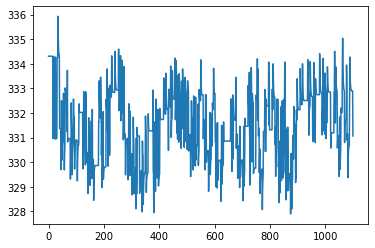

In [11]:
env = Environment(100)
env.advance(1000)

import matplotlib.pyplot as plt
plt.plot(env.history)
plt.show()

Not horribly exciting. Next week we'll start making our actors act "intelligently".